# Comparación de Modelos de Similitud: SBERT vs E5

**Objetivo**: Evaluar y comparar dos arquitecturas de embeddings para similitud semántica de productos de e-commerce.

| Modelo | Arquitectura | Dimensión | Características |
|--------|--------------|-----------|----------------|
| **SBERT** | paraphrase-multilingual-mpnet-base-v2 | 768 | Optimizado para paráfrasis multilingüe |
| **E5** | intfloat/multilingual-e5-base | 768 | Embeddings universales con prefijo `passage:` |

**Secciones**:
1. Carga y Preprocesamiento
2. Generación de Embeddings
3. Análisis de Distribuciones de Similitud
4. Comparación de Rankings (Nearest Neighbors)
5. Análisis de Discrepancias
6. Conclusiones

---
## 1. Setup y Carga de Datos

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_colwidth', 80)

from utils_similarity import (
    preprocess_dataframe,
    ProductSimilarity,
    ModelComparator,
    calcular_estadisticas_similitud,
    compare_nearest_neighbors,
    evaluate_ranking_consistency
)

print("Librerías cargadas correctamente")

Librerías cargadas correctamente


In [ ]:
# Cargar datasets
df_train = pd.read_csv('items_titles.csv')
df_test = pd.read_csv('items_titles_test.csv')

print(f"Dataset TRAIN: {len(df_train):,} productos")
print(f"Dataset TEST:  {len(df_test):,} productos")

Dataset TRAIN: 30,000 productos
Dataset TEST:  10,000 productos


In [ ]:
# Preprocesamiento
df_train = preprocess_dataframe(df_train, column='ITE_ITEM_TITLE', output_column='title_clean')
df_test = preprocess_dataframe(df_test, column='ITE_ITEM_TITLE', output_column='title_clean')

# Ejemplos de preprocesamiento
print("Ejemplos de preprocesamiento:")
for i in range(3):
    print(f"  Original: {df_train['ITE_ITEM_TITLE'].iloc[i][:60]}...")
    print(f"  Clean:    {df_train['title_clean'].iloc[i][:60]}...")
    print()

Ejemplos de preprocesamiento:
  Original: Tênis Ascension Posh Masculino - Preto E Vermelho ...
  Clean:    tênis ascension posh masculino preto e vermelho...

  Original: Tenis Para Caminhada Super Levinho Spider Corrida ...
  Clean:    tenis para caminhada super levinho spider corrida...

  Original: Tênis Feminino Le Parc Hocks Black/ice Original Envio Já...
  Clean:    tênis feminino le parc hocks black ice original envio já...



---
## 2. Generación de Embeddings

In [ ]:
# Configuración
SAMPLE_SIZE = 5000  # Muestra para comparación

# Preparar muestra
np.random.seed(42)
titles_test_clean = df_test['title_clean'].tolist()
titles_test_original = df_test['ITE_ITEM_TITLE'].tolist()

if len(titles_test_clean) > SAMPLE_SIZE:
    sample_idx = np.random.choice(len(titles_test_clean), SAMPLE_SIZE, replace=False)
    titles_sample_clean = [titles_test_clean[i] for i in sample_idx]
    titles_sample_original = [titles_test_original[i] for i in sample_idx]
else:
    titles_sample_clean = titles_test_clean
    titles_sample_original = titles_test_original

print(f"Muestra para comparación: {len(titles_sample_clean):,} productos")

Muestra para comparación: 5,000 productos


In [ ]:
%%time
# Inicializar comparador y agregar modelos
comparator = ModelComparator()
comparator.add_model('sbert', 'sbert')
comparator.add_model('e5', 'e5')

# Generar embeddings para ambos modelos
comparator.fit_all(
    titles=titles_sample_clean,
    titles_original=titles_sample_original,
    batch_size=64,
    show_progress=True
)

Modelo 'sbert' agregado para comparación
Modelo 'e5' agregado para comparación

Procesando modelo: sbert
Cargando modelo: paraphrase-multilingual-mpnet-base-v2...
Modelo cargado. Dimensión: 768
Generando embeddings para 5,000 productos...


Batches: 100%|██████████| 79/79 [00:08<00:00,  9.01it/s]


Embeddings generados. Shape: (5000, 768)

Procesando modelo: e5
Cargando modelo: intfloat/multilingual-e5-base...
Modelo cargado. Dimensión: 768
Generando embeddings para 5,000 productos...


Batches: 100%|██████████| 79/79 [00:09<00:00,  8.03it/s]

Embeddings generados. Shape: (5000, 768)

✓ Todos los modelos procesados (2 modelos)
CPU times: user 5.97 s, sys: 1.89 s, total: 7.86 s
Wall time: 1min 3s


In [ ]:
# Estadísticas de embeddings
print("Estadísticas de Embeddings:")
comparator.get_embedding_stats()

Estadísticas de Embeddings:


,Modelo,Dimensión,Samples,Norma Media,Norma Std,Media Componentes,Std Componentes
0,sbert,768,5000,2.48555,2.456845e-01,0.002381,0.090095
1,e5,768,5000,1.00000,4.254953e-08,-0.000095,0.036084


---
## 3. Análisis de Distribuciones de Similitud

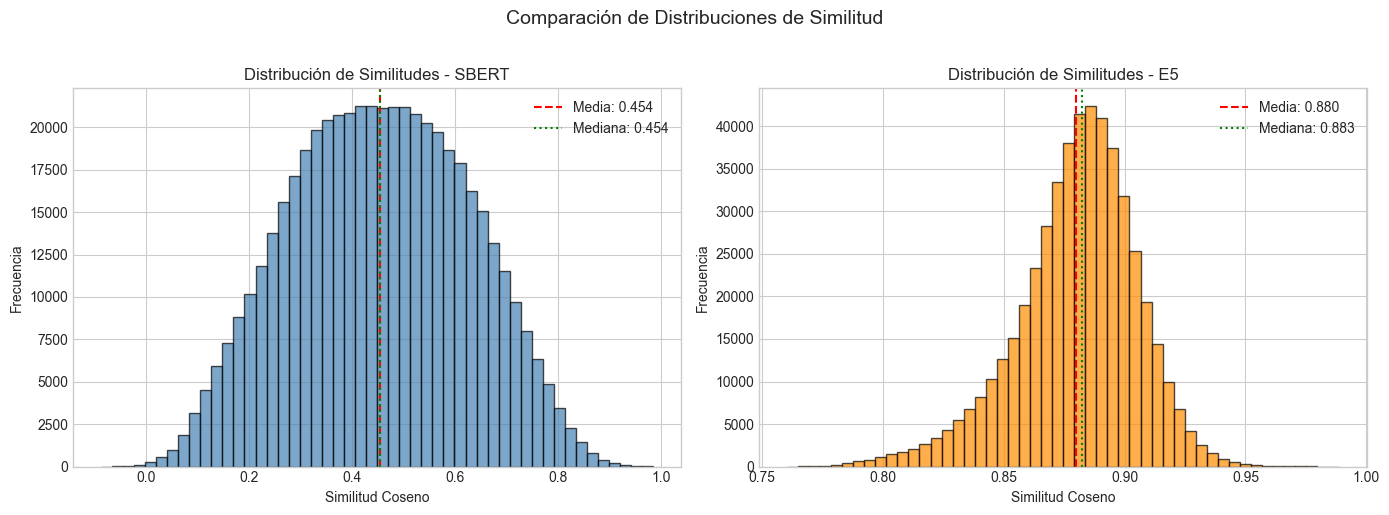

,Modelo,Media,Std,Mediana,Min,Max
0,SBERT,0.4538,0.1724,0.4537,-0.0871,0.9848
1,E5,0.8801,0.0250,0.8826,0.7603,0.9889


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Calcular distribuciones de similitud para ambos modelos
sample_for_dist = 1000
np.random.seed(42)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
stats_summary = []

for ax, (name, emb) in zip(axes, comparator.embeddings.items()):
    # Muestrear
    idx = np.random.choice(len(emb), min(sample_for_dist, len(emb)), replace=False)
    emb_sample = emb[idx]
    
    # Calcular matriz de similitud
    sim_matrix = cosine_similarity(emb_sample)
    mask = np.triu(np.ones_like(sim_matrix, dtype=bool), k=1)
    sim_values = sim_matrix[mask]
    
    # Estadísticas
    stats_summary.append({
        'Modelo': name.upper(),
        'Media': np.mean(sim_values),
        'Std': np.std(sim_values),
        'Mediana': np.median(sim_values),
        'Min': np.min(sim_values),
        'Max': np.max(sim_values)
    })
    
    # Histograma
    color = 'steelblue' if 'sbert' in name else 'darkorange'
    ax.hist(sim_values, bins=50, color=color, alpha=0.7, edgecolor='black')
    ax.axvline(np.mean(sim_values), color='red', linestyle='--', 
              label=f'Media: {np.mean(sim_values):.3f}')
    ax.axvline(np.median(sim_values), color='green', linestyle=':', 
              label=f'Mediana: {np.median(sim_values):.3f}')
    ax.set_xlabel('Similitud Coseno')
    ax.set_ylabel('Frecuencia')
    ax.set_title(f'Distribución de Similitudes - {name.upper()}')
    ax.legend()

plt.suptitle('Comparación de Distribuciones de Similitud', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Tabla resumen
pd.DataFrame(stats_summary).round(4)

### Correlación entre Scores de Modelos

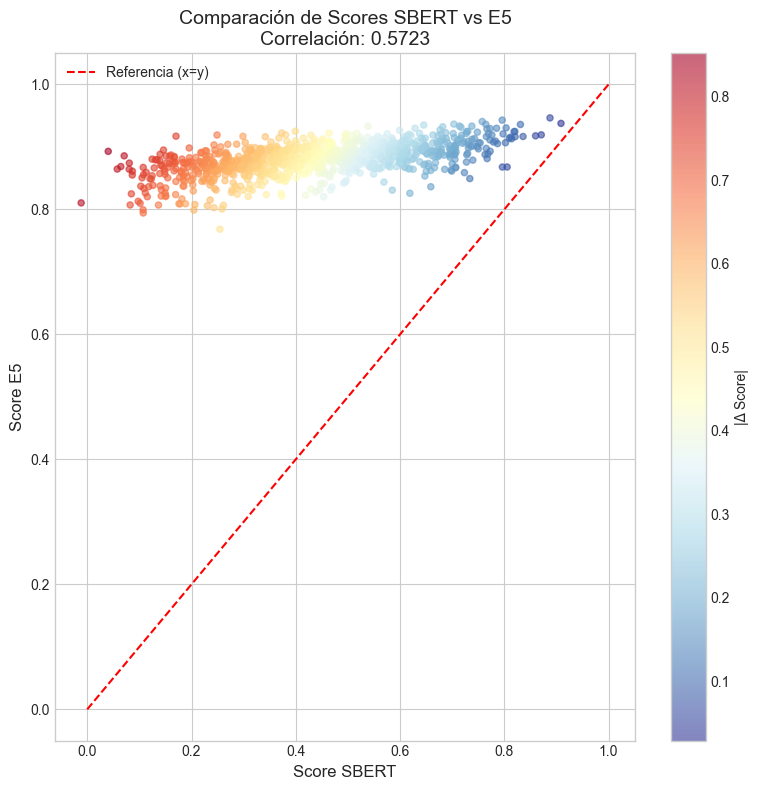


Correlación de Pearson entre scores: 0.5723


In [ ]:
# Calcular scores para pares aleatorios
n_pairs = 1000
np.random.seed(42)

pairs_idx = []
for _ in range(n_pairs * 2):
    i, j = np.random.randint(0, len(titles_sample_clean), 2)
    if i != j:
        pairs_idx.append((i, j))
    if len(pairs_idx) >= n_pairs:
        break

# Calcular scores para cada modelo
scores_sbert = []
scores_e5 = []

for idx1, idx2 in pairs_idx:
    scores_sbert.append(comparator.models['sbert'].get_similarity_by_index(idx1, idx2))
    scores_e5.append(comparator.models['e5'].get_similarity_by_index(idx1, idx2))

# Scatter plot
correlation = np.corrcoef(scores_sbert, scores_e5)[0, 1]

fig, ax = plt.subplots(figsize=(8, 8))
scatter = ax.scatter(scores_sbert, scores_e5, 
                    c=np.abs(np.array(scores_sbert) - np.array(scores_e5)),
                    cmap='RdYlBu_r', alpha=0.6, s=20)
ax.plot([0, 1], [0, 1], 'r--', label='Referencia (x=y)')
ax.set_xlabel('Score SBERT', fontsize=12)
ax.set_ylabel('Score E5', fontsize=12)
ax.set_title(f'Comparación de Scores SBERT vs E5\nCorrelación: {correlation:.4f}', fontsize=14)
ax.legend()
plt.colorbar(scatter, label='|Δ Score|')
plt.tight_layout()
plt.show()

print(f"\nCorrelación de Pearson entre scores: {correlation:.4f}")

---
## 4. Comparación de Rankings (Nearest Neighbors)

In [ ]:
# Evaluar consistencia de rankings
ranking_metrics = evaluate_ranking_consistency(
    comparator.models['sbert'],
    comparator.models['e5'],
    n_queries=100,
    k=10
)

print("Métricas de Consistencia de Rankings:")
print(f"  - Overlap@10 promedio: {ranking_metrics['mean_overlap@10']:.2%}")
print(f"  - Std Overlap@10: {ranking_metrics['std_overlap@10']:.2%}")
print(f"  - Correlación de Ranking promedio: {ranking_metrics['mean_rank_correlation']:.4f}")

Métricas de Consistencia de Rankings:
  - Overlap@10 promedio: 26.40%
  - Std Overlap@10: 19.31%
  - Correlación de Ranking promedio: 0.2831


In [ ]:
# Ejemplos de nearest neighbors para productos específicos
np.random.seed(42)
query_indices = np.random.choice(len(titles_sample_clean), 5, replace=False)

nn_comparison = compare_nearest_neighbors(
    comparator.models['sbert'],
    comparator.models['e5'],
    query_indices=query_indices.tolist(),
    k=5,
    titles_original=titles_sample_original
)

print("\nComparación de Top-5 Vecinos Más Cercanos:")
for _, row in nn_comparison.iterrows():
    print(f"\nQuery: {row['Query']}")
    print(f"  SBERT: {row['Model1_Top_K'][0][:50]}...")
    print(f"  E5:    {row['Model2_Top_K'][0][:50]}...")
    print(f"  Overlap@5: {row['Overlap@5']} ({row['Overlap@5_%']}%)")


Comparación de Top-5 Vecinos Más Cercanos:

Query: Tênis Infantil Masculino Feminino Frete Gratis.
  SBERT: Tênis Infantil Led Lindos Frete Grátis!!...
  E5:    Tênis Infantil Led Lindos Frete Grátis!!...
  Overlap@5: 1 (20.0%)

Query: Tênis Liberte Kids Fluidfit Preto Rosa
  SBERT: Tênis Infantil De Led Rosa...
  E5:    Tênis Menina Vorax Preto Rose...
  Overlap@5: 0 (0.0%)

Query: Tênis Sneaker Feminino Sola Plataforma Metalizado 
  SBERT: Tênis Feminino Em Couro Legítimo New Kra...
  E5:    Tênis Mississipi Sola Alta Feminino Snea...
  Overlap@5: 1 (20.0%)

Query: Tênis Casual Star Branco Preto Esportivo Confortáv
  SBERT: Tênis Moleca Matelassê Branco Preto Conf...
  E5:    Sapatênis Tênis Casual Masculino Leve Co...
  Overlap@5: 0 (0.0%)

Query: Tênis Botinha Carolina Cb21-459
  SBERT: Tênis Feminino Sua Cia 8199.13258...
  E5:    Tênis Mississipi Jogging Neville Branco ...
  Overlap@5: 0 (0.0%)


---
## 5. Análisis de Discrepancias

In [ ]:
# Encontrar pares con mayor discrepancia entre modelos
discrepancies = comparator.get_top_disagreements(n_pairs=500, top_k=10)

print("Top 10 Pares con Mayor Discrepancia entre SBERT y E5:")
display_cols = ['Producto 1', 'Producto 2', 'Score_sbert', 'Score_e5', 'Max_Discrepancia']

for i, row in discrepancies.iterrows():
    print(f"\n{i+1}. Discrepancia: {row['Max_Discrepancia']:.4f}")
    print(f"   P1: {row['Producto 1'][:60]}...")
    print(f"   P2: {row['Producto 2'][:60]}...")
    print(f"   SBERT: {row['Score_sbert']:.4f} | E5: {row['Score_e5']:.4f}")

Top 10 Pares con Mayor Discrepancia entre SBERT y E5:

493. Discrepancia: 0.8526
   P1: Tenis Feminino Sapatenis Conforto Meia Plataforma...
   P2: Tênis Mizuno Wave Prophecy 6 -  Ref***0000057...
   SBERT: 0.0403 | E5: 0.8928

450. Discrepancia: 0.8148
   P1: Tênis Sapatênis Mule Colorido Now United Come Together Band...
   P2: Tênis Wave Force Masculino Academia Caminhada Bom Barato...
   SBERT: 0.0709 | E5: 0.8857

293. Discrepancia: 0.8069
   P1: Smart Tv LG 49 Uj6300 Com Defeito Na Tela...
   P2: Tênis Infantil Menina Molekinha Nude/ Ouro Rosado...
   SBERT: 0.0576 | E5: 0.8645

236. Discrepancia: 0.8041
   P1: Tênis Esportivo Feminino Asics Gel-kihai 2...
   P2: Tv Philco 32  Modelo Ph32f33dg Led...
   SBERT: 0.0645 | E5: 0.8686

14. Discrepancia: 0.7934
   P1: Ponteira, Reparo Para Cabos De Vassoura E Rodos, Plastico...
   P2: Tênis Sapatênis Mule Super Mário World Psicoélico Terror...
   SBERT: 0.0807 | E5: 0.8741

355. Discrepancia: 0.7838
   P1: Bicicleta Mtb Oggi Hacker Hds 

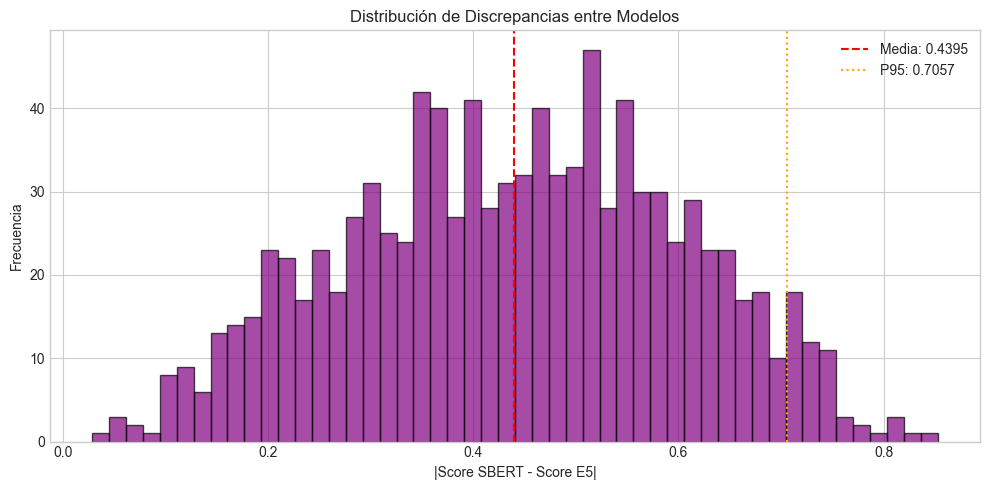


Estadísticas de Discrepancias:
  Media: 0.4395
  Mediana: 0.4451
  Max: 0.8526
  P95: 0.7057


In [ ]:
# Distribución de discrepancias
all_diffs = np.abs(np.array(scores_sbert) - np.array(scores_e5))

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(all_diffs, bins=50, color='purple', alpha=0.7, edgecolor='black')
ax.axvline(np.mean(all_diffs), color='red', linestyle='--', 
          label=f'Media: {np.mean(all_diffs):.4f}')
ax.axvline(np.percentile(all_diffs, 95), color='orange', linestyle=':', 
          label=f'P95: {np.percentile(all_diffs, 95):.4f}')
ax.set_xlabel('|Score SBERT - Score E5|')
ax.set_ylabel('Frecuencia')
ax.set_title('Distribución de Discrepancias entre Modelos')
ax.legend()
plt.tight_layout()
plt.show()

print(f"\nEstadísticas de Discrepancias:")
print(f"  Media: {np.mean(all_diffs):.4f}")
print(f"  Mediana: {np.median(all_diffs):.4f}")
print(f"  Max: {np.max(all_diffs):.4f}")
print(f"  P95: {np.percentile(all_diffs, 95):.4f}")

---
## 6. Conclusiones

### Resumen de Hallazgos

In [ ]:
# Resumen final
print("=" * 60)
print("RESUMEN DE COMPARACIÓN SBERT vs E5")
print("=" * 60)

print("\n1. CARACTERÍSTICAS DE EMBEDDINGS:")
for stat in stats_summary:
    print(f"   {stat['Modelo']}:")
    print(f"     - Similitud media: {stat['Media']:.4f}")
    print(f"     - Desviación estándar: {stat['Std']:.4f}")

print(f"\n2. CORRELACIÓN ENTRE MODELOS:")
print(f"   - Correlación de Pearson: {correlation:.4f}")
print(f"   - Los modelos tienen {'alta' if correlation > 0.8 else 'moderada' if correlation > 0.5 else 'baja'} concordancia")

print(f"\n3. CONSISTENCIA DE RANKINGS:")
print(f"   - Overlap@10: {ranking_metrics['mean_overlap@10']:.2%}")
print(f"   - Correlación de ranking: {ranking_metrics['mean_rank_correlation']:.4f}")

print(f"\n4. DISCREPANCIAS:")
print(f"   - Discrepancia media: {np.mean(all_diffs):.4f}")
print(f"   - Discrepancia máxima: {np.max(all_diffs):.4f}")
print(f"   - 95% de los pares tienen discrepancia < {np.percentile(all_diffs, 95):.4f}")

print("\n" + "=" * 60)
print("RECOMENDACIÓN:")
if ranking_metrics['mean_overlap@10'] > 0.6:
    print("Los modelos muestran alta concordancia. Cualquiera es adecuado")
    print("para producción, con preferencia por E5 si se busca normalización.")
else:
    print("Los modelos muestran diferencias significativas.")
    print("Se recomienda evaluar con datos etiquetados para decidir.")
print("=" * 60)

RESUMEN DE COMPARACIÓN SBERT vs E5

1. CARACTERÍSTICAS DE EMBEDDINGS:
   SBERT:
     - Similitud media: 0.4538
     - Desviación estándar: 0.1724
   E5:
     - Similitud media: 0.8801
     - Desviación estándar: 0.0250

2. CORRELACIÓN ENTRE MODELOS:
   - Correlación de Pearson: 0.5723
   - Los modelos tienen moderada concordancia

3. CONSISTENCIA DE RANKINGS:
   - Overlap@10: 26.40%
   - Correlación de ranking: 0.2831

4. DISCREPANCIAS:
   - Discrepancia media: 0.4395
   - Discrepancia máxima: 0.8526
   - 95% de los pares tienen discrepancia < 0.7057

RECOMENDACIÓN:
Los modelos muestran diferencias significativas.
Se recomienda evaluar con datos etiquetados para decidir.
